In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

## Convert MNIST to Torch Tensors

In [44]:
use_cuda = torch.cuda.is_available()
use_cuda

In [45]:
transform = transforms.ToTensor()  
# There are many other transforms, for this one, we only use ToTensor

In [46]:
train_data = datasets.MNIST(root='../PYTORCH_NOTEBOOKS/Data',
                            train=True,
                            download=True,
                            transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../PYTORCH_NOTEBOOKS/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [47]:
test_data = datasets.MNIST(root='../PYTORCH_NOTEBOOKS/Data',
                           train=False,
                           download=True,
                           transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../PYTORCH_NOTEBOOKS/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [48]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


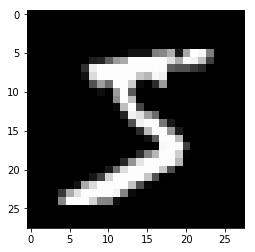

In [49]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

## Data Loader

In [50]:
torch.manual_seed(101)  # for consistent results
train_loader = DataLoader(train_data,
                          batch_size=10,
                          shuffle=True,
                          pin_memory=True)
test_loader = DataLoader(test_data,
                         batch_size=10,
                         shuffle=False,
                         pin_memory=True)

Labels:  [    0     5     7     8     6     7     9     7     1     3]


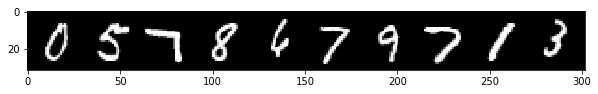

In [51]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:10].numpy())

# Print the first 12 images
im = make_grid(images[:10], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the Model

In [52]:
# Using ANN (For Reference only - not used in this example)
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        # Wrapper method for ReLU
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)  # Softmax not Sigmoid

In [12]:
# Using CNN
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        # Gray scale so only 1 channel, 6 filters
        self.conv1 = nn.Conv2d(1, 6, 3, 1) 
        # Above: 6 filters -> pooling
        # Size after conv2d = (28 -3 + 1) = 26x26
        # Size after max pool = 13x13
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # Above: 16 filters -> pooling
        # Size after conv2d = (13 -3 + 1) = 11x11
        # Size after max pool = 5x5
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        # below is essentially flattening and taking batch size into account
        X = X.view(-1, 5*5*16)  # -1 so that we can vary the batch size
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [13]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
if use_cuda:
    model = model.cuda()

next(model.parameters()).is_cuda # Need to send model to GPU as well.

True

In [15]:
# Count Parameters (Optional)

In [16]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [17]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Flattening the Images (Not Needed for CNN)

In [19]:
# # Load the first batch, print its shape
# for images, labels in train_loader:
#     print('Batch shape:', images.size())
#     break
    
# # EQUIVALENT TO:
# # dataiter = iter(train_loader)
# # images, labels = dataiter.next()
# # print('Batch shape:', images.size())

In [20]:
# # Load the first batch, print its shape
# for images, labels in train_loader:
#     print('Batch shape:', images.size())
#     break
    
# # EQUIVALENT TO:
# # dataiter = iter(train_loader)
# # images, labels = dataiter.next()
# # print('Batch shape:', images.size())

In [21]:
# images.view(100,-1).size()

## Train the model

In [22]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        if use_cuda:
            X_train, y_train = X_train.cuda(), y_train.cuda()
        
        # Apply the model
        # y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        y_pred = model(X_train)  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{train_loader.batch_size*b:6}/{len(train_data)})]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(train_loader.batch_size*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            if use_cuda:
                X_test, y_test = X_test.cuda(), y_test.cuda()
            
            # Apply the model
            # y_val = model(X_test.view(500, -1))  # Here we flatten X_test
            y_val = model(X_test)  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000)]  loss: 0.21157122  accuracy:  78.233%
epoch:  0  batch: 1200 [ 12000/60000)]  loss: 0.54952776  accuracy:  85.317%
epoch:  0  batch: 1800 [ 18000/60000)]  loss: 0.05257447  accuracy:  88.444%
epoch:  0  batch: 2400 [ 24000/60000)]  loss: 0.02388734  accuracy:  90.242%
epoch:  0  batch: 3000 [ 30000/60000)]  loss: 0.00784931  accuracy:  91.447%
epoch:  0  batch: 3600 [ 36000/60000)]  loss: 0.00494886  accuracy:  92.242%
epoch:  0  batch: 4200 [ 42000/60000)]  loss: 0.06191576  accuracy:  92.831%
epoch:  0  batch: 4800 [ 48000/60000)]  loss: 0.00274764  accuracy:  93.358%
epoch:  0  batch: 5400 [ 54000/60000)]  loss: 0.00046723  accuracy:  93.789%
epoch:  0  batch: 6000 [ 60000/60000)]  loss: 0.00934979  accuracy:  94.148%
epoch:  1  batch:  600 [  6000/60000)]  loss: 0.10715421  accuracy:  97.867%
epoch:  1  batch: 1200 [ 12000/60000)]  loss: 0.22486667  accuracy:  97.850%
epoch:  1  batch: 1800 [ 18000/60000)]  loss: 0.22534768  accuracy:  97.778%

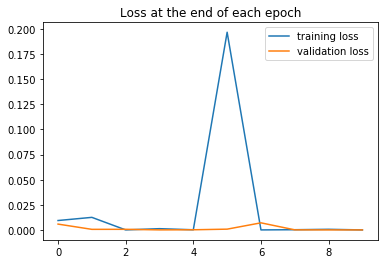

In [23]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

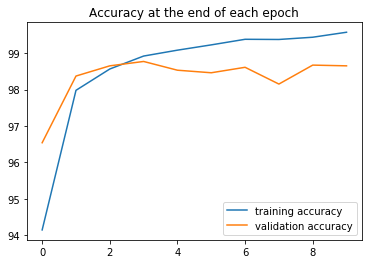

In [24]:
plt.plot([float(t)/len(train_data)*100 for t in train_correct], label='training accuracy')
plt.plot([float(t)/len(test_data)*100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [25]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [27]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        if use_cuda:
            X_test, y_test = X_test.cuda(), y_test.cuda()
        
        #y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        y_val = model(X_test)  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9865/10000 =  98.650%


In [28]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1).cpu(), y_test.view(-1).cpu()))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 977    4    2    1    0    2    6    1    2    2]
 [   0 1118    0    1    0    0    2    2    0    0]
 [   0    1 1024    1    0    1    0    2    2    0]
 [   0    3    0  994    0    5    0    2    1    1]
 [   0    0    0    0  961    0    3    0    0    2]
 [   0    2    0    9    2  881    5    0    1    3]
 [   2    2    0    0    2    1  940    0    0    0]
 [   1    1    5    1    0    0    0 1010    1    1]
 [   0    4    1    3    3    2    2    2  965    5]
 [   0    0    0    0   14    0    0    9    2  995]]


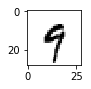

In [29]:
# Single Image

x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [43]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28).cuda()).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9
